In [73]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Handle table-like data and matrices
import numpy as np
import pandas as pd

# Modelling Algorithms
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier

# Modelling Helpers
from sklearn.preprocessing import Imputer , Normalizer , scale
from sklearn.cross_validation import train_test_split , StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import LabelEncoder

# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4
# Configure visualisations
#%matplotlib inline
mpl.style.use( 'ggplot' )
sns.set_style( 'white' )
sns.set(color_codes=True) # Set style and color of graphs

train = pd.read_csv("/Users/houzhuo/Downloads/train.csv")
test    = pd.read_csv("/Users/houzhuo/Downloads/test.csv")
full = train.append(test,ignore_index=True)
titanic = full[:891]
print ('Datasets:' , 'full:' , full.shape , 'titanic:' , titanic.shape)
full.info()

('Datasets:', 'full:', (1309, 12), 'titanic:', (891, 12))
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
Age            1046 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
Fare           1308 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


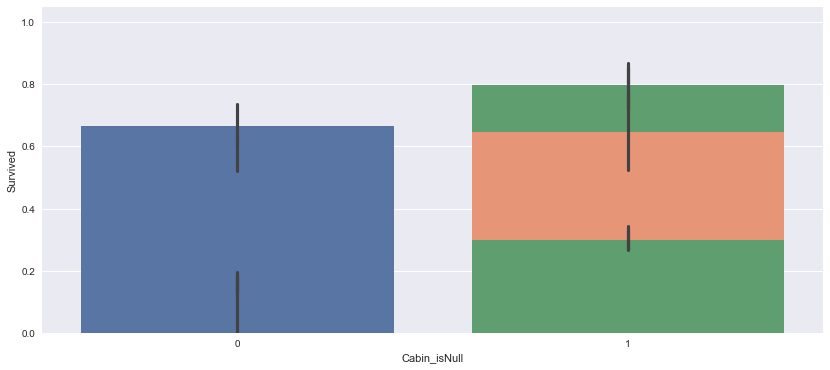

In [74]:
#Title
title = pd.DataFrame()
full['Title'] = full['Name'].map(lambda name:name.split(',')[1].split( '.' )[0].strip())
plt.figure(figsize=(14,6))
sns.barplot('Title', 'Survived', data=full)
#plt.show()
full['Title'] = full['Title'].replace(['Don','Dona', 'Major', 'Capt', 'Jonkheer', 'Rev', 'Col','Sir','Dr'],'Mr')
full['Title'] = full['Title'].replace(['Mlle','Ms'], 'Miss')
full['Title'] = full['Title'].replace(['the Countess','Mme','Lady','Dr'], 'Mrs')
title = pd.get_dummies(full['Title'],prefix='Title')
full = pd.concat([full,title],axis=1)
sns.barplot('Title', 'Survived', data=full)

#Age & isChild
group = full.groupby(['Sex','Title', 'Pclass'])['Age']
full['Age'] = group.transform(lambda x: x.fillna(x.median()))
full['IsChild'] = np.where(full['Age']<=12,1,0)
full['IsOld'] = np.where(full['Age']>=63,1,0)

#Dead_female_family & Survive_male_family
full['Surname'] = full['Name'].apply(lambda x:x.split(',')[0])
dead_female_surname = list(set(full[(full.Sex=='female') & (full.Age>=12)
                              & (full.Survived==0) & ((full.Parch>0) | (full.SibSp > 0))]['Surname'].values))
survive_male_surname = list(set(full[(full.Sex=='male') & (full.Age>=12)
                              & (full.Survived==1) & ((full.Parch>0) | (full.SibSp > 0))]['Surname'].values))
full['Dead_female_family'] = np.where(full['Surname'].isin(dead_female_surname),0,1)
full['Survive_male_family'] = np.where(full['Surname'].isin(survive_male_surname),0,1)
#full = full.drop(['Name','Surname'],axis=1)

#FamilySize
full['FamilySize'] = np.where(full['SibSp']+full['Parch']==0, 'Alone',
                                    np.where(full['SibSp']+full['Parch']<=3, 'Small', 'Big'))
sns.barplot('FamilySize', 'Survived', data=full)
df = pd.get_dummies(full['FamilySize'],prefix='FamilySize')
full = pd.concat([full,df],axis=1).drop(['SibSp','Parch','FamilySize'],axis=1)

#Ticket_letter
full['Ticket_Lett'] = full['Ticket'].apply(lambda x: str(x)[0])
full['Ticket_Lett'] = full['Ticket_Lett'].apply(lambda x: str(x))
sns.barplot('Ticket_Lett', 'Survived', data=full)
full['High_Survival_Ticket'] = np.where(full['Ticket_Lett'].isin(['1', '2', 'P']),1,0)
full['Low_Survival_Ticket'] = np.where(full['Ticket_Lett'].isin(['A','W','3','7']),1,0)
#full = full.drop(['Ticket','Ticket_Lett'],axis=1)

#Embarked
#full = full.drop('Embarked',axis=1)
full['Embarked_isC'] = np.where(full['Embarked']=='C',1,0)
#sns.barplot('Embarked_isC','Survived',data=full)

#Cabin
full[ 'Cabin' ] = full.Cabin.fillna( 'U' )
full['Cabin_isNull'] = np.where(full['Cabin']=='U',1,0)
sns.barplot('Cabin_isNull','Survived',data=full)
full = full.drop('Cabin',axis=1)

#PClass
df = pd.get_dummies(full['Pclass'],prefix='Pclass')
full = pd.concat([full,df],axis=1).drop('Pclass',axis=1)

#Sex
full['Sex'] = pd.Series( np.where( full.Sex == 'male' , 1 , 0 ) , name = 'Sex' )

#Fare
full['Fare'].fillna(full['Fare'].dropna().median(),inplace=True)
full['Low_Fare'] = np.where(full['Fare']<=8.66,1,0)
full['High_Fare'] = np.where(full['Fare']>=26,1,0)
#Ticket_count
#full["TicketCount"] = full.Ticket.apply(lambda x: 1 if x in full.Ticket.unique() and
                                        #full.Ticket.value_counts()[x] > 1  else 0)
#np.where(full['TicketCount']=='CA. 2343')
#full["TicketCount"]

In [75]:
full_X = full
full_X = full_X.drop('PassengerId',axis=1)
full_X = full_X.drop('Survived',axis=1)
full_X = full_X.drop('Embarked',axis=1)
full_X = full_X.drop('Age',axis=1)
full_X = full_X.drop('Name',axis=1)
full_X = full_X.drop('Surname',axis=1)
full_X = full_X.drop('Title',axis=1)
full_X = full_X.drop('Fare',axis=1)
full_X = full_X.drop('Ticket',axis=1)
full_X = full_X.drop('Ticket_Lett',axis=1)

In [76]:
X_train= full_X[ 0:891 ]
y_train = titanic.Survived
X_test = full_X[ 891: ]
print (full_X.shape , X_train.shape , X_test.shape , y_train.shape )
X_train.info()

((1309, 21), (891, 21), (418, 21), (891,))
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 21 columns):
Sex                     891 non-null int64
Title_Master            891 non-null uint8
Title_Miss              891 non-null uint8
Title_Mr                891 non-null uint8
Title_Mrs               891 non-null uint8
IsChild                 891 non-null int64
IsOld                   891 non-null int64
Dead_female_family      891 non-null int64
Survive_male_family     891 non-null int64
FamilySize_Alone        891 non-null uint8
FamilySize_Big          891 non-null uint8
FamilySize_Small        891 non-null uint8
High_Survival_Ticket    891 non-null int64
Low_Survival_Ticket     891 non-null int64
Embarked_isC            891 non-null int64
Cabin_isNull            891 non-null int64
Pclass_1                891 non-null uint8
Pclass_2                891 non-null uint8
Pclass_3                891 non-null uint8
Low_Fare                891 non-nul

In [77]:
from sklearn.cross_validation import KFold
# Some useful parameters which will come in handy later on
ntrain = X_train.shape[0]
ntest = X_test.shape[0]
SEED = 0 # for reproducibility
NFOLDS = 5 # set folds for out-of-fold prediction
kf = KFold(ntrain, n_folds= NFOLDS, random_state=SEED)

# Class to extend the Sklearn classifier
class SklearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self,x,y):
        return self.clf.fit(x,y)
    
    def feature_importances(self,x,y):
        print(self.clf.fit(x,y).feature_importances_)
    

In [78]:
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))#891*1
    oof_test = np.zeros((ntest,))#418*1
    oof_test_skf = np.empty((NFOLDS, ntest))#418*5

    for i, (train_index, test_index) in enumerate(kf):
        x_tr = x_train[train_index]#712*21
        y_tr = y_train[train_index]#712*1
        x_te = x_train[test_index]#179*21

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)#5 coloums

    oof_test[:] = oof_test_skf.mean(axis=0)#418*1
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

In [91]:
# Put in our parameters for said classifiers
# Random Forest parameters
rf_params = {
    'n_jobs': -1,
    'n_estimators': 50,
     'warm_start': True, 
     #'max_features': 0.2,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'verbose': 0
}

# Extra Trees Parameters
et_params = {
    'n_jobs': -1,
    'n_estimators':50,
    #'max_features': 0.5,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 0
}

# AdaBoost parameters
ada_params = {
    'n_estimators': 50,
    'learning_rate' : 0.75
}

# Gradient Boosting parameters
gb_params = {
    'n_estimators': 50,
     #'max_features': 0.2,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0
}

# Support Vector Classifier parameters 
svc_params = {
    'kernel' : 'linear',
    'C' : 0.025
    }

knn_params = {
    'n_neighbors' : 3
    }
lr_params = {
    'tol':0.0001,
    'C':1.0
    }

nb_params = {
    
    }


In [96]:
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
# Create 5 objects that represent our 4 models
rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
et = SklearnHelper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
#ada = SklearnHelper(clf=AdaBoostClassifier, seed=SEED, params=ada_params)
gb = SklearnHelper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)
svc = SklearnHelper(clf=SVC, seed=SEED, params=svc_params)
lr = SklearnHelper(clf=LogisticRegression ,seed=SEED,params=lr_params)
#nb = SklearnHelper(clf=GaussianNB, seed=SEED,params=nb_params)
#knn = SklearnHelper(clf=KNeighborsClassifier, params=knn_params)

In [81]:
# Create Numpy arrays of train, test and target ( Survived) dataframes to feed into our models
train_y = y_train.ravel()
train_X = X_train.values # Creates an array of the train data
test_X = X_test.values # Creats an array of the test data


In [105]:
from sklearn.model_selection import cross_val_score
# Create our OOF train and test predictions. These base results will be used as new features
et_oof_train, et_oof_test = get_oof(et, train_X, train_y, test_X) # Extra Trees
rf_oof_train, rf_oof_test = get_oof(rf,train_X, train_y, test_X) # Random Forest
#ada_oof_train, ada_oof_test = get_oof(ada, train_X, train_y, test_X) # AdaBoost 
gb_oof_train, gb_oof_test = get_oof(gb,train_X, train_y, test_X) # Gradient Boost
svc_oof_train, svc_oof_test = get_oof(svc,train_X, train_y, test_X) # Support Vector Classifier
lr_oof_train, lr_oof_test = get_oof(lr,train_X, train_y, test_X)
#lr_oof_train, lr_oof_test = get_oof(lr,train_X, train_y, test_X)
print("Training is complete")
np.mean(_oof_train.ravel() == y_train)  

Training is complete


0.88664421997755327

In [83]:
base_predictions_train = pd.DataFrame( {'RandomForest': rf_oof_train.ravel(),
     'ExtraTrees': et_oof_train.ravel(),
     #'AdaBoost': ada_oof_train.ravel(),
      'GradientBoost': gb_oof_train.ravel(),
    'SVC': svc_oof_train.ravel(),
      'LogisticRegression': lr_oof_train.ravel()                                  
    })
base_predictions_train.head()

,ExtraTrees,GradientBoost,LogisticRegression,RandomForest,SVC
0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0,1.0
2,1.0,1.0,1.0,1.0,1.0
3,1.0,1.0,1.0,1.0,1.0
4,0.0,0.0,0.0,0.0,0.0


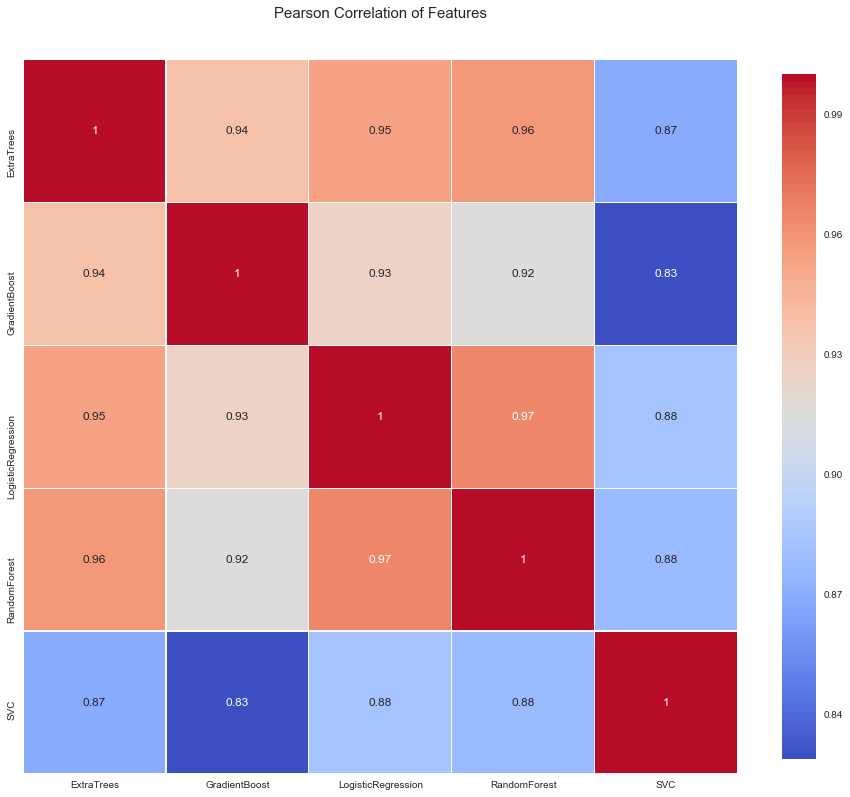

In [84]:

def correlation_heatmap(df):
    _ , ax = plt.subplots(figsize =(16, 14))
    colormap = sns.diverging_palette(220, 10, as_cmap = True)
    colormap = sns.color_palette("coolwarm", 100)
    
    _ = sns.heatmap(
        df.corr(), 
        cmap = colormap,
        square=True, 
        cbar_kws={'shrink':.9 }, 
        ax=ax,
        annot=True, 
        linewidths=0.1,vmax=1.0, linecolor='white',
        annot_kws={'fontsize':12 }
    )
    
    plt.title('Pearson Correlation of Features', y=1.05, size=15)

correlation_heatmap(base_predictions_train)

In [85]:
final_train = np.concatenate(( et_oof_train, rf_oof_train, ada_oof_train, gb_oof_train, svc_oof_train,lr_oof_train), axis=1)
final_test = np.concatenate(( et_oof_test, rf_oof_test, ada_oof_test, gb_oof_test, svc_oof_test,lr_oof_test), axis=1)

In [86]:
import xgboost as xgb
gbm = xgb.XGBClassifier(
    #learning_rate = 0.02,
 n_estimators= 50,
 max_depth= 4,
 min_child_weight= 2,
 #gamma=1,
 gamma=0.9,                        
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread= -1,
 scale_pos_weight=1).fit(final_train, y_train)
predictions = gbm.predict(final_test)

In [87]:
passenger_id = full[891:].PassengerId
test = pd.DataFrame( { 'PassengerId': passenger_id , 'Survived': predictions.astype(np.int64) } )
#test.shape
#test.head()
test.to_csv( 'titanic_pred.csv' , index = False )

In [97]:
from sklearn import datasets

iris = datasets.load_iris()
X, y = iris.data[:, 1:3], iris.target

In [100]:
X


array([[ 3.5,  1.4],
       [ 3. ,  1.4],
       [ 3.2,  1.3],
       [ 3.1,  1.5],
       [ 3.6,  1.4],
       [ 3.9,  1.7],
       [ 3.4,  1.4],
       [ 3.4,  1.5],
       [ 2.9,  1.4],
       [ 3.1,  1.5],
       [ 3.7,  1.5],
       [ 3.4,  1.6],
       [ 3. ,  1.4],
       [ 3. ,  1.1],
       [ 4. ,  1.2],
       [ 4.4,  1.5],
       [ 3.9,  1.3],
       [ 3.5,  1.4],
       [ 3.8,  1.7],
       [ 3.8,  1.5],
       [ 3.4,  1.7],
       [ 3.7,  1.5],
       [ 3.6,  1. ],
       [ 3.3,  1.7],
       [ 3.4,  1.9],
       [ 3. ,  1.6],
       [ 3.4,  1.6],
       [ 3.5,  1.5],
       [ 3.4,  1.4],
       [ 3.2,  1.6],
       [ 3.1,  1.6],
       [ 3.4,  1.5],
       [ 4.1,  1.5],
       [ 4.2,  1.4],
       [ 3.1,  1.5],
       [ 3.2,  1.2],
       [ 3.5,  1.3],
       [ 3.1,  1.5],
       [ 3. ,  1.3],
       [ 3.4,  1.5],
       [ 3.5,  1.3],
       [ 2.3,  1.3],
       [ 3.2,  1.3],
       [ 3.5,  1.6],
       [ 3.8,  1.9],
       [ 3. ,  1.4],
       [ 3.8,  1.6],
       [ 3.2,